# Anyone AI

# Project III - Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all together. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.

## Introduction

Kaggle is a web platform and community for data scientist and machine learning engineers where competetitions and datasets are regularly published.

This particular competition is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay its debt or not. The competition finished 4 years ago, so you will find a lot of blog posts and code written for it, we encourage you to read everything you can about it.

The dataset is composed of multiple files with different information about loands taken. In this project we're going to exclusively work with the main files: application_train.csv and application_test.csv.

The competition uses [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

### Getting the data

1- Login to Kaggle (if you don't have an account you'll have to register to get it) and download the [complete dataset](https://www.kaggle.com/competitions/home-credit-default-risk/data). Read the information about the data. What does a row in the main file represent? What does the target variable means?

One row represents one loan in our data sample.
The target variable says wether the loan was repaid (0) or not (1)

The main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

2- Load the training and test datasets, we're only going to work withe "application_train.csv" and "application_test.csv" for now

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
import re
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
### Complete in this cell: Loading the dataset
train_df=pd.read_csv('application_train.csv')
train_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
test_df=pd.read_csv('application_test.csv')
test_df

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


### Exploratory Data Analysis

A lot of the analysis of the data can be found on public available Kaggle kernels or blog posts, but you need to make sure you understand the datasets properties before starting working on it, so we'll do exploratory data analysis for the main files

**Dataset Basics**

1- Show the shape of the training and test datasets.

In [4]:
### Complete in this cell: shape of the dataset
print(f'Train dataset has {train_df.shape[0]} rows and {train_df.shape[1]} columns')
print(f'Test dataset has {test_df.shape[0]} rows and {test_df.shape[1]} columns')

Train dataset has 307511 rows and 122 columns
Test dataset has 48744 rows and 121 columns


2- List all columns in the train dataset

In [5]:
### Complete in this cell: Show all columns in the training dataset 
train_df.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

3- Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

In [6]:
pd.set_option("max_rows", None)#This line can show all the rows of the df.
pd.set_option('max_colwidth', None)
columns_description=pd.read_csv('HomeCredit_columns_description.csv')
columns_description[columns_description.Table=='application_{train|test}.csv'][['Row','Description']]
#This dataset show you a description of each column in all datasets

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT,Credit amount of the loan
9,AMT_ANNUITY,Loan annuity


In [7]:
pd.set_option('max_columns', None)



In [8]:
### Complete in this cell: show first 5 records in a transposed table

train_df.head(5).T

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
FLAG_OWN_REALTY,Y,N,Y,Y,Y
CNT_CHILDREN,0,0,0,0,0
AMT_INCOME_TOTAL,202500.0,270000.0,67500.0,135000.0,121500.0
AMT_CREDIT,406597.5,1293502.5,135000.0,312682.5,513000.0
AMT_ANNUITY,24700.5,35698.5,6750.0,29686.5,21865.5


In [9]:
pd.reset_option('max_rows')
pd.reset_option('max_colwidth')

#Came back to show only few rows of the dataframe

4- Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

In [10]:
### Complete in this cell: show distribution of target variable
print('Total value count of each target')
print(train_df.TARGET.value_counts(),'\n')
print('Percentage of each target')
print(train_df.TARGET.value_counts()/train_df.shape[0]*100)

Total value count of each target
0    282686
1     24825
Name: TARGET, dtype: int64 

Percentage of each target
0    91.927118
1     8.072882
Name: TARGET, dtype: float64


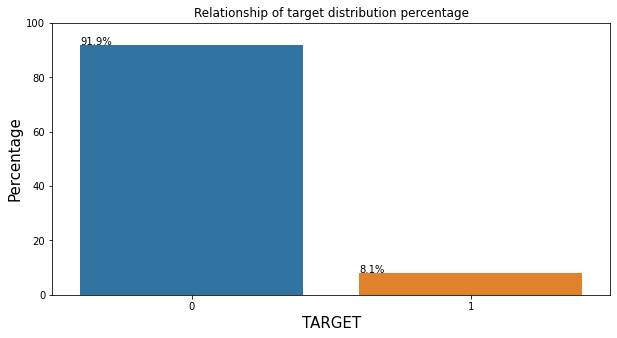

In [11]:
TARGET_percent=train_df['TARGET'].value_counts(normalize=True)*100
plt.rcParams['figure.figsize'] = [10, 5]
g=sns.barplot(x=TARGET_percent.index, y=TARGET_percent.values)
plt.title('Relationship of target distribution percentage')
for p in g.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)

plt.ylim(0,100)
plt.xlabel('TARGET',size=15)
plt.ylabel('Percentage',size=15)
plt.show()

5- Show the number of columns of each data type

In [12]:
numerical_col=train_df.select_dtypes(include='number').columns.to_list()
int_col=train_df.select_dtypes(include='Int64').columns.to_list()
float_col=train_df.select_dtypes(include='Float64').columns.to_list()
categorical_col=train_df.select_dtypes(include='object').columns.to_list()

In [13]:
### Complete in this cell: show number of columns per data type
print(f'number of numerical data type columns: {len(numerical_col)}')
print(f'Of which {len(int_col)} are integers values and {len(float_col)} are float values')
print(f'number of categorical data type columns: {len(categorical_col)}')


number of numerical data type columns: 106
Of which 41 are integers values and 65 are float values
number of categorical data type columns: 16


In [14]:
#remove this columns from the list because these will not use to preprocessing later.
numerical_col.remove('SK_ID_CURR')
numerical_col.remove('TARGET')

6- For categorical variables, show the number of distinct values in each column (number of labels)

In [15]:
### Complete in this cell: show number of unique values per categorical column
for col in categorical_col:
    print(train_df[col].value_counts(),'\n')

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64 

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64 

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64 

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64 

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64 

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64 

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Nam

7- Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

In [16]:
### Complete in this cell: checking missing data
pd.set_option('precision', 2)
print('Train set null')
(train_df.isna().sum() / train_df.shape[0] * 100).sort_values(ascending=False).head(20)

Train set null


COMMONAREA_MEDI             69.87
COMMONAREA_AVG              69.87
COMMONAREA_MODE             69.87
NONLIVINGAPARTMENTS_MODE    69.43
NONLIVINGAPARTMENTS_AVG     69.43
NONLIVINGAPARTMENTS_MEDI    69.43
FONDKAPREMONT_MODE          68.39
LIVINGAPARTMENTS_MODE       68.35
LIVINGAPARTMENTS_AVG        68.35
LIVINGAPARTMENTS_MEDI       68.35
FLOORSMIN_AVG               67.85
FLOORSMIN_MODE              67.85
FLOORSMIN_MEDI              67.85
YEARS_BUILD_MEDI            66.50
YEARS_BUILD_MODE            66.50
YEARS_BUILD_AVG             66.50
OWN_CAR_AGE                 65.99
LANDAREA_MEDI               59.38
LANDAREA_MODE               59.38
LANDAREA_AVG                59.38
dtype: float64

In [17]:
print('Test set null')
(test_df.isna().sum() / test_df.shape[0] * 100).sort_values(ascending=False).head(20)

Test set null


COMMONAREA_AVG              68.72
COMMONAREA_MODE             68.72
COMMONAREA_MEDI             68.72
NONLIVINGAPARTMENTS_AVG     68.41
NONLIVINGAPARTMENTS_MODE    68.41
NONLIVINGAPARTMENTS_MEDI    68.41
FONDKAPREMONT_MODE          67.28
LIVINGAPARTMENTS_AVG        67.25
LIVINGAPARTMENTS_MODE       67.25
LIVINGAPARTMENTS_MEDI       67.25
FLOORSMIN_MEDI              66.61
FLOORSMIN_AVG               66.61
FLOORSMIN_MODE              66.61
OWN_CAR_AGE                 66.29
YEARS_BUILD_AVG             65.28
YEARS_BUILD_MEDI            65.28
YEARS_BUILD_MODE            65.28
LANDAREA_MEDI               57.96
LANDAREA_AVG                57.96
LANDAREA_MODE               57.96
dtype: float64

**Analyzing distribution of variables**

1- Show the distribution of credit amounts

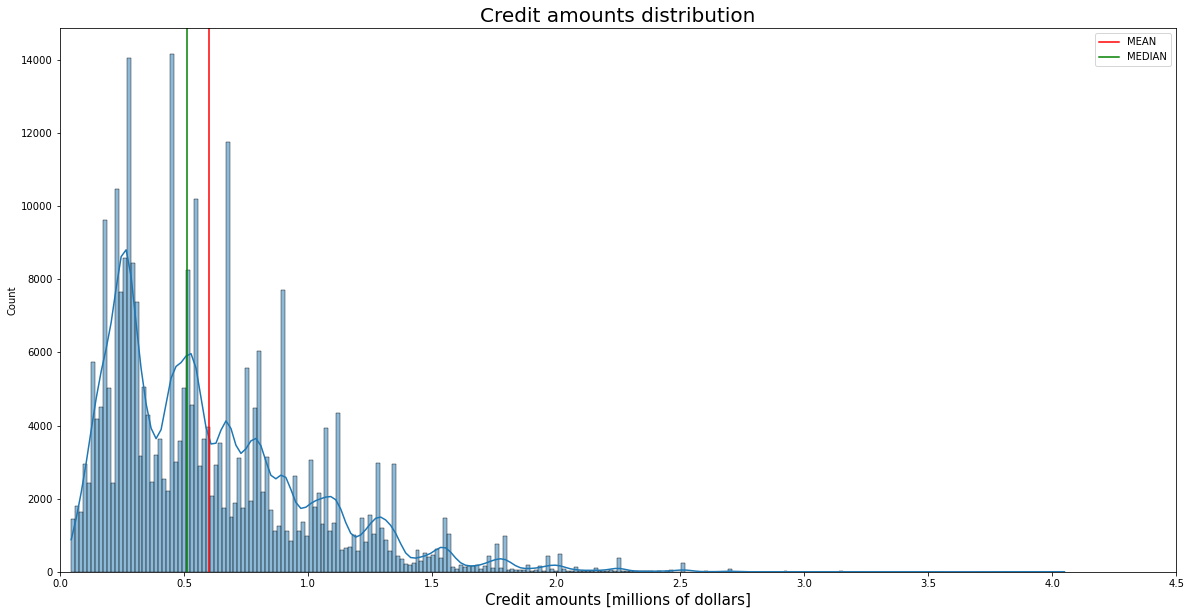

In [18]:
### Complete in this cell: distribution of credit amounts
plt.rcParams['figure.figsize'] = [20, 10]

graph=sns.histplot(x='AMT_CREDIT',data=train_df,kde=True,stat='count')
plt.xticks(graph.get_xticks(), graph.get_xticks() / 1000000)
plt.xlim(left=0)
plt.axvline(train_df['AMT_CREDIT'].mean(),color='red', label="MEAN")
plt.axvline(train_df['AMT_CREDIT'].median(),color='green', label="MEDIAN")
plt.legend()
plt.title('Credit amounts distribution', size=20)
plt.xlabel('Credit amounts [millions of dollars]',size=15)

plt.show()


2- Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

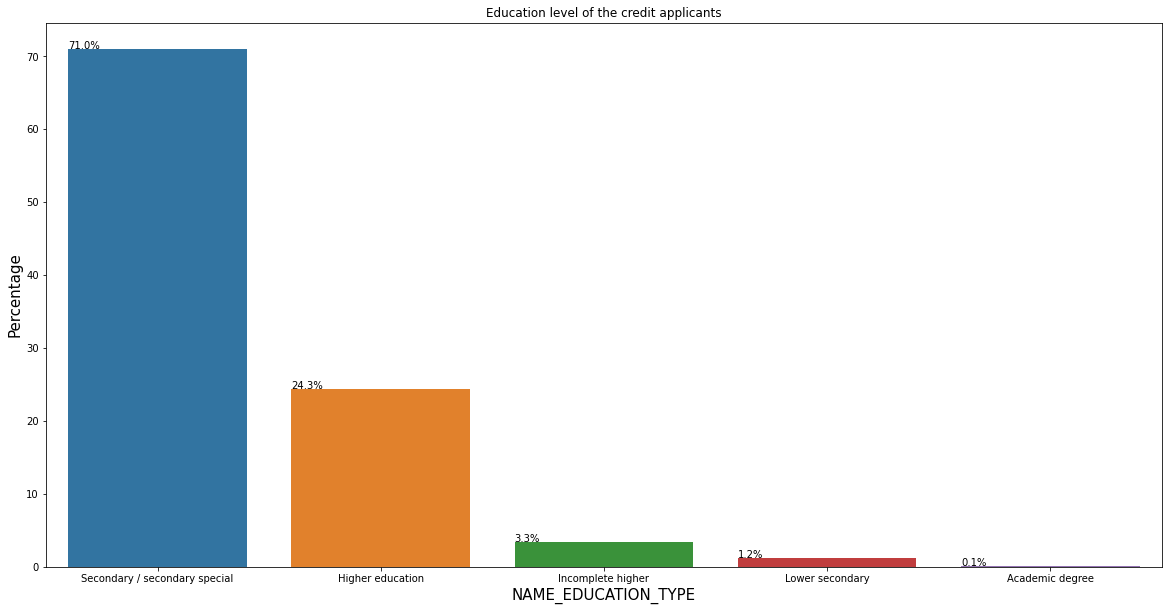

In [19]:
NAME_EDUCATION_TYPE_percent=train_df['NAME_EDUCATION_TYPE'].value_counts(normalize=True)*100
g=sns.barplot(x=NAME_EDUCATION_TYPE_percent.index, y=NAME_EDUCATION_TYPE_percent.values)
plt.title('Education level of the credit applicants')
for p in g.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)

plt.xlabel('NAME_EDUCATION_TYPE',size=15)
plt.ylabel('Percentage',size=15)
plt.show()

In [20]:
print(train_df['NAME_EDUCATION_TYPE'].value_counts())

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64


3- Plot the distribution of ocupation of the loan applicants

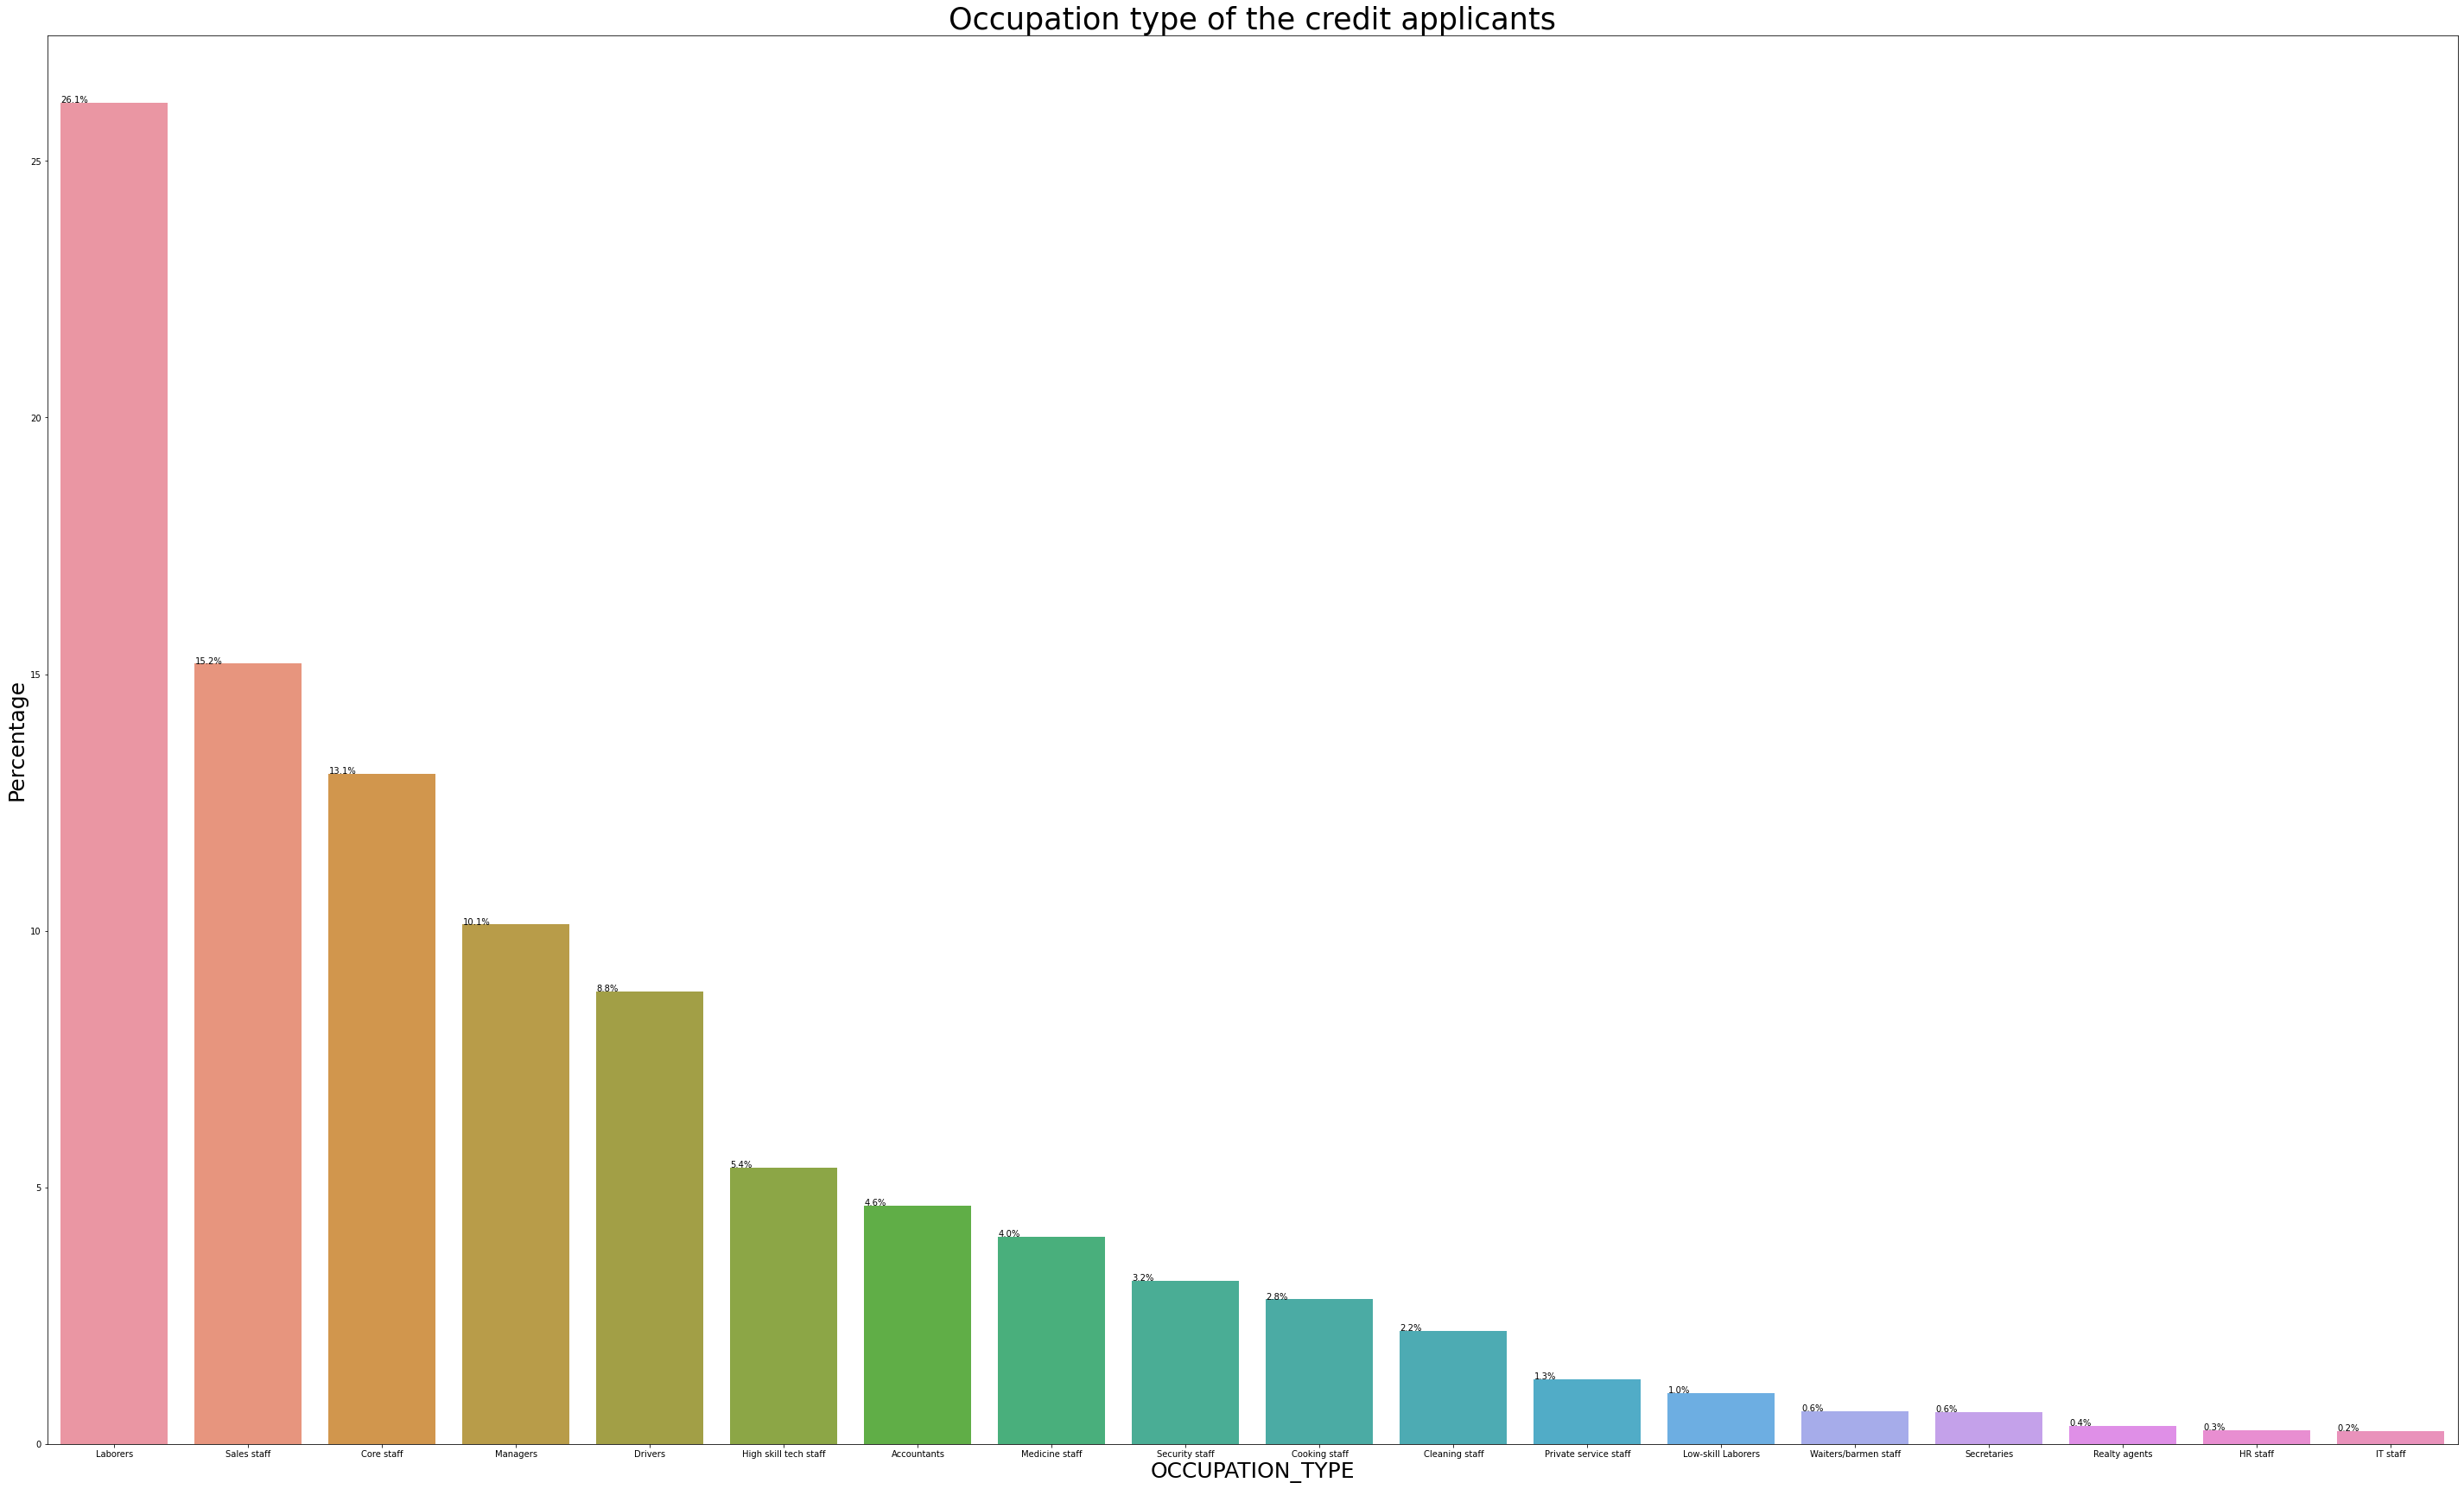

In [21]:
### Complete in this cell: ocupation of applicants
OCCUPATION_TYPE_percent=train_df['OCCUPATION_TYPE'].value_counts(normalize=True)*100
plt.rcParams['figure.figsize'] = [50, 30]

g=sns.barplot(x=OCCUPATION_TYPE_percent.index, y=OCCUPATION_TYPE_percent.values)
plt.title('Occupation type of the credit applicants',size=35)
for p in g.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)

#plt.ylim(0,100)
plt.xlabel('OCCUPATION_TYPE',size=25)
plt.ylabel('Percentage',size=25)
plt.show()

4- Plot the family status of the applicants

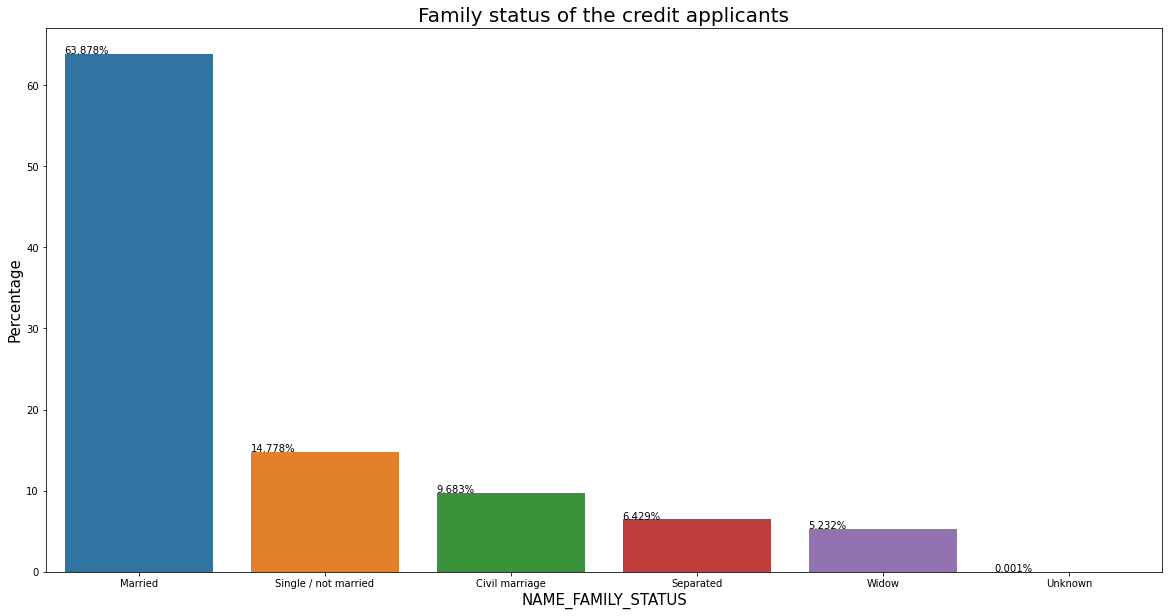

In [22]:
### Complete in this cell: family status

NAME_FAMILY_STATUS_percent=train_df['NAME_FAMILY_STATUS'].value_counts(normalize=True)*100
plt.rcParams['figure.figsize'] = [20, 10]

g=sns.barplot(x=NAME_FAMILY_STATUS_percent.index, y=NAME_FAMILY_STATUS_percent.values)
plt.title('Family status of the credit applicants',size=20)
for p in g.patches:
    txt = str(p.get_height().round(3)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)

#plt.ylim(0,100)
plt.xlabel('NAME_FAMILY_STATUS',size=15)
plt.ylabel('Percentage',size=15)
plt.show()

5- Plot the income type of applicants grouped by the target variable

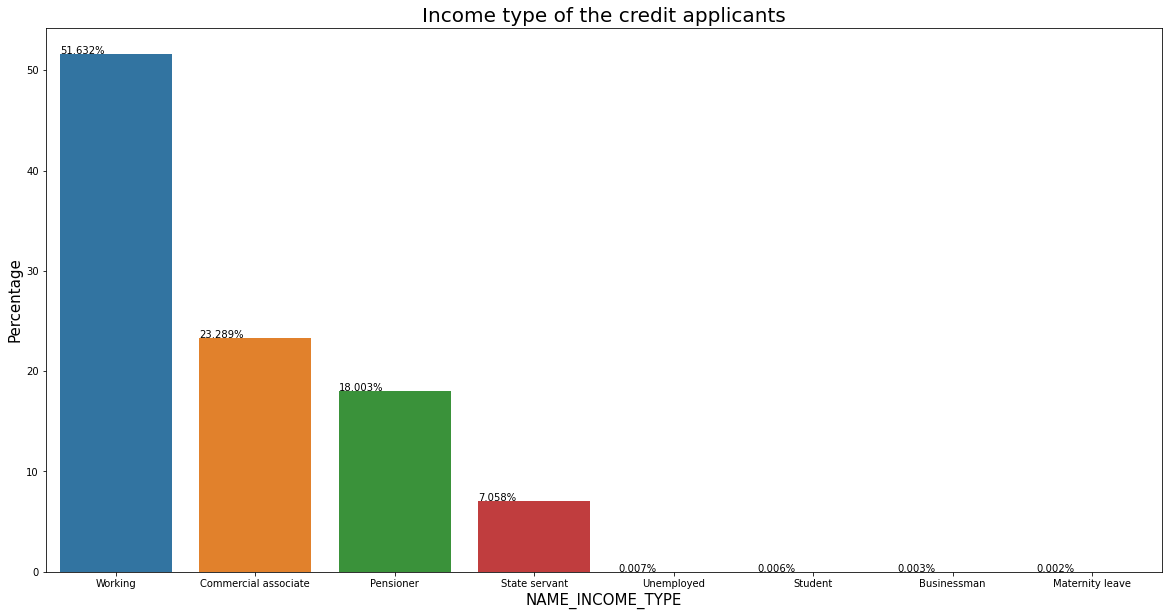

In [23]:
### Complete in this cell: Income type of applicants by target variable

NAME_INCOME_TYPE_percent=train_df['NAME_INCOME_TYPE'].value_counts(normalize=True)*100
plt.rcParams['figure.figsize'] = [20, 10]

g=sns.barplot(x=NAME_INCOME_TYPE_percent.index, y=NAME_INCOME_TYPE_percent.values)
plt.title('Income type of the credit applicants',size=20)
for p in g.patches:
    txt = str(p.get_height().round(3)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)

#plt.ylim(0,100)
plt.xlabel('NAME_INCOME_TYPE',size=15)
plt.ylabel('Percentage',size=15)
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


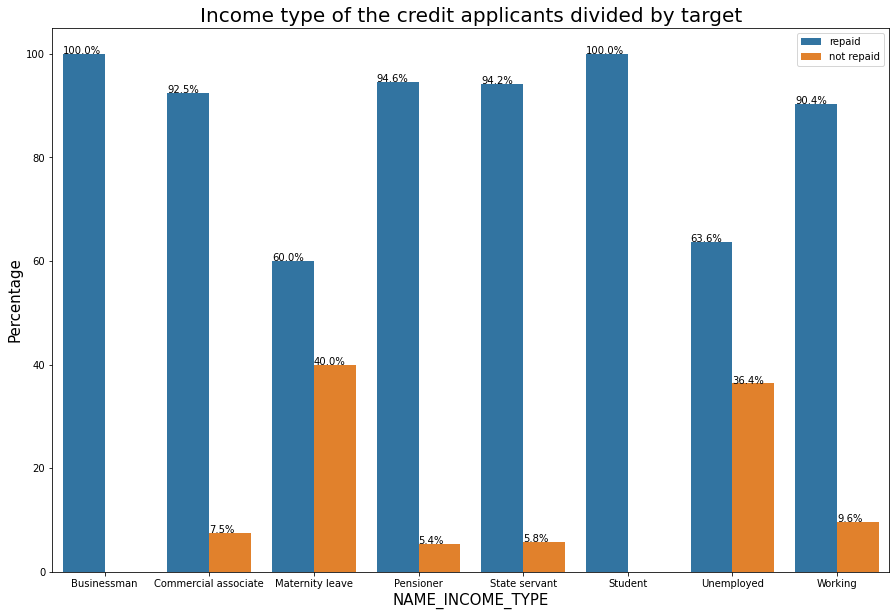

In [24]:
new_df = train_df.groupby('NAME_INCOME_TYPE')['TARGET'].value_counts(normalize=True)*100
new_df = new_df.rename('Percent').reset_index()
new_df.TARGET=new_df.TARGET.replace([0,1],['repaid','not repaid'])
plt.rcParams['figure.figsize'] = [15, 10]
g = sns.barplot(x='NAME_INCOME_TYPE', y='Percent', hue='TARGET', data=new_df)
for p in g.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)
plt.legend(fontsize=10)
plt.title('Income type of the credit applicants divided by target',size=20)
plt.xlabel('NAME_INCOME_TYPE',size=15)
plt.ylabel('Percentage',size=15)
plt.xticks(fontsize=10)
plt.show()

## Preprocessing

In this section, you will code a function to make all the data pre processing for the dataset. What you have to deliver is a function that takes the train and test dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities:

- Correct outliers/anomalous values in numerical columns (hint: take a look at the DAYS_EMPLOYED column)
- Impute values for all columns with missing data (use median as imputing value)
- Encode categorical features:
    - If feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
- Feature scaling

Keep in mind that you could get different number of columns in train and test because some category could only be present in one of the dataframes, this could create more one hot encoded columns. You should align train and test to have the same number of columns

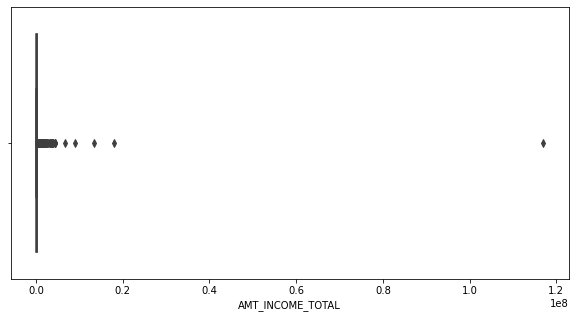

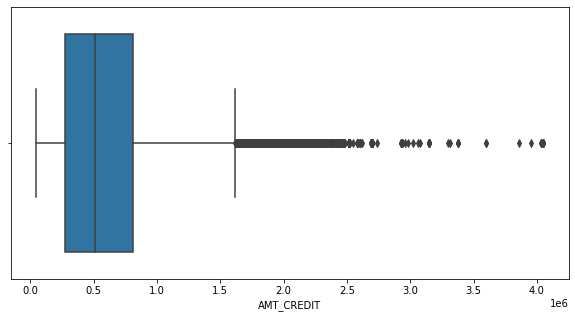

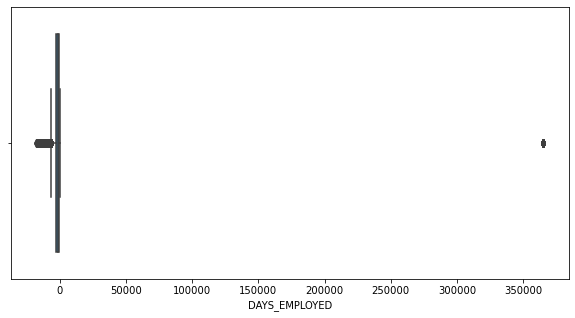

In [25]:
plt.rcParams['figure.figsize'] = [10, 5]
list_col_outliers=['AMT_INCOME_TOTAL','AMT_CREDIT','DAYS_EMPLOYED']
for num_col in list_col_outliers:
    sns.boxplot(x=num_col,data=train_df)
    plt.show()

These columns will we use to remove the outliers.

In [26]:
def remove_outlier(work_df,num_col, iqr_factor=1.5):
    """
    IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
    accept a dataframe, remove outliers, return cleaned data with nans in the outliers space.
    see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
    """
    q1 = work_df[num_col].quantile(0.25)
    q3 = work_df[num_col].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    work_df.loc[ work_df[num_col] > fence_high, num_col] = np.nan
    work_df.loc[ work_df[num_col] < fence_low, num_col] = np.nan
    return work_df

def remove_numerical_nan(work_df,test_df_copy,num_col):
    '''
    This function imputes nans to numerical columns. If the column has more than 3 unique values it will impute with
    the median of all this column. Otherwise, it will be treated as a categorical column imputing the most frequent 
    value.
    This is because the dataset has some columns with flags that if it imputes with the median it will have a new 
    value different from the flag.
    '''
    if work_df[num_col].unique().size > 3:
        imp_median=SimpleImputer(missing_values=np.nan,strategy='median')
        imp_median.fit(work_df[[num_col]])
        work_df[num_col] = imp_median.transform(work_df[[num_col]])
        test_df_copy[num_col] = imp_median.transform(test_df_copy[[num_col]])
    else:
        imp_moda_num=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
        imp_moda_num.fit(work_df[[num_col]])
        work_df[num_col] = imp_moda_num.transform(work_df[[num_col]])
        test_df_copy[num_col] = imp_moda_num.transform(test_df_copy[[num_col]])
        #This columns are categorical but encoding in numerical values. I manage them like a categoorical value.
    return work_df,test_df_copy
    
def remove_categorical_nan(work_df,test_df_copy,cat_col):
    '''
    This function imputes nans to categorical columns. It will be impute with the most frequent value. 
    '''
    imp_moda_cat=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
    imp_moda_cat.fit(work_df[[cat_col]])
    work_df[cat_col] = imp_moda_cat.transform(work_df[[cat_col]])
    test_df_copy[cat_col] = imp_moda_cat.transform(test_df_copy[[cat_col]])
    
    return work_df,test_df_copy

def categorical_encoding(work_df,test_df_copy,cat_col):
    '''
    This function encodes the categorical features. If the features has more than 2 unique values, it will create a 
    one hot encoder of each specific category with pandas get dummies function. Otherwise, will transform its column 
    in 1 and 0 values with label encoder from sklearn.
    '''
    le = LabelEncoder()
    if work_df[cat_col].unique().size > 2:
        df_dummies=pd.get_dummies(work_df[[cat_col]])
        work_df=pd.concat([work_df,df_dummies],axis=1)
        work_df=work_df.drop([cat_col], axis=1)
        
        df_dummies=pd.get_dummies(test_df_copy[[cat_col]])
        test_df_copy=pd.concat([test_df_copy,df_dummies],axis=1)
        test_df_copy=test_df_copy.drop([cat_col], axis=1)
    else:
        le.fit(work_df[cat_col])
        work_df[cat_col]=le.transform(work_df[cat_col])
        test_df_copy[cat_col]=le.transform(test_df_copy[cat_col])
    
    return work_df,test_df_copy

def scaling(work_df,test_df_copy,num_col):
    '''
    This function scales the numerical data but only if its range is more than 0 to 3. This is because in this 
    dataset we already have features normalized and flags that we don't want to change these values.
    '''
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    if not work_df[num_col].between(0,3).all():
    #scale only columns that have range more than 0 to 3 because there are flags that we dont want to modify.
        work_df[num_col]=scaler.fit_transform(work_df[num_col].values.reshape(-1,1))
        test_df_copy[num_col]=scaler.transform(test_df_copy[num_col].values.reshape(-1,1))
        
    return work_df,test_df_copy

In [27]:
### Complete in this cell: Data pre processing function    
def preprocessing(work_df,test_df_copy,list_col_outliers,numerical_col,categorical_col):
    '''
    This function will take training and testing dataframe, and preprocessing all its columns. 
    First will remove outliers from a name list that user decide. Then imputes nan for numerical features and scaling
    these features to the same range of values. And for categorical features will impute nans and encode into 
    numerical values. 
    Finally align both dataframes to the same number of columns.
    '''

    #remove otliers
    for num_col in list_col_outliers:
        work_df=remove_outlier(work_df,num_col)
    
    for num_col in numerical_col:
        #dealing with nan values  
        work_df,test_df_copy=remove_numerical_nan(work_df,test_df_copy,num_col)
        #scaling
        work_df,test_df_copy=scaling(work_df,test_df_copy,num_col)
   
    for cat_col in categorical_col:
        #dealing with nan values  
        work_df,test_df_copy=remove_categorical_nan(work_df,test_df_copy,cat_col)
        #encoding  
        work_df,test_df_copy=categorical_encoding(work_df,test_df_copy,cat_col)
    
    #align the columns variables. Those columns that test set dont have, will have 0. Drop target column from test set.        
    work_df,test_df_copy=work_df.align(test_df_copy,axis=1,fill_value=0)
    test_df_copy=test_df_copy.drop(['TARGET'], axis=1)
    
    return work_df,test_df_copy

In [28]:
%%time
work_df=train_df.copy().drop(labels=['SK_ID_CURR'],axis=1)
#work_df
test_df_copy=test_df.copy().drop(labels=['SK_ID_CURR'],axis=1)
list_col_outliers=['AMT_INCOME_TOTAL','AMT_CREDIT','DAYS_EMPLOYED']

work_df,test_df_copy=preprocessing(work_df,test_df_copy,list_col_outliers,numerical_col,categorical_col)

CPU times: user 10.8 s, sys: 4.91 s, total: 15.7 s
Wall time: 15.7 s


In [29]:
work_df

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORG

In [30]:
test_df_copy

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORG

## Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

### Baseline: LogisticRegression

1- Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter 

In [31]:
X_train=work_df.drop(labels=['TARGET'],axis=1)
y_train=work_df.TARGET
X_test=test_df_copy

In [32]:
X_test

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORG

In [33]:
### Complete in this cell: train a logistic regression 
lr_model = LogisticRegression(C=0.01,max_iter=1000,random_state=42)#,random_state=42)
lr_model.fit(X_train,y_train)


LogisticRegression(C=0.01, max_iter=1000, random_state=42)

2- Use the trained model to predict probabilites for the test data, and then save the results to a csv in the format expected in the competition: a SK_ID_CURR column and a TARGET column with probabilities. REMEMBER: the TARGET columns should ONLY contain the probabilities that the debt is not repaid (equivalent to the class 1).

In [34]:
### Complete in this cell: predict test data and save csv
y_pred=lr_model.predict_proba(X_test)
kaggle_df=pd.DataFrame()
kaggle_df['SK_ID_CURR']=test_df['SK_ID_CURR']
kaggle_df['TARGET']=y_pred[:,1]
kaggle_df.to_csv('log_reg_baseline.csv', index = False)

In [35]:
kaggle_df

,SK_ID_CURR,TARGET
0,100001,0.05
1,100005,0.19
2,100013,0.04
3,100028,0.04
4,100038,0.13
...,...,...
48739,456221,0.04
48740,456222,0.06
48741,456223,0.05
48742,456224,0.06


3- Go to the Kaggle competition, and in the [submissions page](https://www.kaggle.com/competitions/home-credit-default-risk/submit) load your csv file. Report here the result in the private score you obtained.

At this point, the model should produce a result around 0.67 

Private score: 0.62850

### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

1- Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for n_jobs, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [36]:
%%time
rf_model=RandomForestClassifier(n_jobs=-1, random_state=42)
rf_model.fit(X_train,y_train)

CPU times: user 6min 50s, sys: 3.85 s, total: 6min 54s
Wall time: 41.1 s


RandomForestClassifier(n_jobs=-1, random_state=42)

2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [37]:
### Complete in this cell: predict test data and save csv
y_pred=rf_model.predict_proba(X_test)
kaggle_df=pd.DataFrame()
kaggle_df['SK_ID_CURR']=test_df['SK_ID_CURR']
kaggle_df['TARGET']=y_pred[:,1]
kaggle_df.to_csv('random_forest_baseline.csv', index = False)

In [38]:
kaggle_df

,SK_ID_CURR,TARGET
0,100001,0.07
1,100005,0.14
2,100013,0.08
3,100028,0.03
4,100038,0.05
...,...,...
48739,456221,0.08
48740,456222,0.08
48741,456223,0.05
48742,456224,0.10


3- Load the predictions to the competition. Report the private score here.

In [39]:
### Complete in this cell: report your score on Kaggle
# This model should have a private score around 0.68 

Private score: 0.67450

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


1- Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier. The validation metric used to evaluate the models should be "roc_auc".

In [40]:
%%time
### Complete in this cell: Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier
param_grid = {
 'bootstrap': [True, False],
 'max_depth': [10, 50, 100,200, None],
 'max_features': ['log2', 'sqrt',None, 50, 10],
 'min_samples_leaf': [1, 2, 4,10],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50,100, 200],
 'criterion':['gini', 'entropy']
}
rf_model=RandomForestClassifier(n_jobs=-1, random_state=42)
random_search_rf=RandomizedSearchCV(rf_model, param_grid, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=5,
                                 random_state=42,verbose=1)
#in this case we use n_iter=10 because i run with more iterations (50), and it takes to much time and the performance 
#is almost the same. So i decide change it to 10 so it can reproduce the result with no longer time. 
random_search_rf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 10min 33s, sys: 10.6 s, total: 10min 43s
Wall time: 1h 25min 5s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 50, 100, 200, None],
                                        'max_features': ['log2', 'sqrt', None,
                                                         50, 10],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [41]:
random_search_rf.best_score_

0.7389488634980766

In [42]:
random_search_rf.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 100,
 'criterion': 'entropy',
 'bootstrap': False}

In [43]:
pd.DataFrame(random_search_rf.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,360.77,8.40,10.43,0.90,200,5,10,log2,100,entropy,False,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.74,0.74,0.74,0.74,0.74,0.74,2.21e-03,1
2,1712.54,31.66,14.04,1.23,200,5,10,50,None,gini,True,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.74,0.74,0.73,0.74,0.74,0.74,1.69e-03,2
4,685.30,16.15,18.70,1.42,200,5,2,sqrt,50,entropy,True,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.74,0.74,0.73,0.74,0.74,0.74,2.27e-03,3
3,223.93,13.23,9.70,0.67,100,10,10,log2,100,entropy,True,"{'n_estimators': 100, 'min_samples_split': 10,...",0.73,0.74,0.73,0.73,0.73,0.73,2.44e-03,4
9,2089.04,32.01,0.98,0.32,100,10,10,None,100,gini,True,"{'n_estimators': 100, 'min_samples_split': 10,...",0.72,0.73,0.72,0.73,0.73,0.73,1.16e-03,5


2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [44]:
### Complete in this cell: predict test data and save csv
y_pred=random_search_rf.predict_proba(X_test)
kaggle_df=pd.DataFrame()
kaggle_df['SK_ID_CURR']=test_df['SK_ID_CURR']
kaggle_df['TARGET']=y_pred[:,1]
kaggle_df.to_csv('random_forest_random_search.csv', index = False)
kaggle_df

,SK_ID_CURR,TARGET
0,100001,0.07
1,100005,0.12
2,100013,0.05
3,100028,0.05
4,100038,0.14
...,...,...
48739,456221,0.05
48740,456222,0.11
48741,456223,0.05
48742,456224,0.06


3- Load the predictions to the competition. Report the private score here.


Private score: 0.72804

4- If you have the time and resources, you can train the model for longer iterations, or select more estimator sizes. This is optional, but if you, we would love to see your results.

### Optional: Training a LightGBM model 

Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [45]:
%%time
### Complete in this cell: train a LightGBM model
lgbm_model_baseline=LGBMClassifier(random_state=42)
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
lgbm_model_baseline.fit(X_train,y_train)

CPU times: user 29.8 s, sys: 1.52 s, total: 31.4 s
Wall time: 4.37 s


LGBMClassifier(random_state=42)

In [46]:
y_pred=lgbm_model_baseline.predict_proba(X_test)
kaggle_df=pd.DataFrame()
kaggle_df['SK_ID_CURR']=test_df['SK_ID_CURR']
kaggle_df['TARGET']=y_pred[:,1]
kaggle_df.to_csv('lgbm_baseline.csv', index = False)
kaggle_df

,SK_ID_CURR,TARGET
0,100001,0.04
1,100005,0.12
2,100013,0.02
3,100028,0.03
4,100038,0.14
...,...,...
48739,456221,0.03
48740,456222,0.08
48741,456223,0.03
48742,456224,0.05


private score: 0.74215

Try random search tunning hyperparameters

In [47]:
%%time
param_grid = {
 'max_depth': [10, 50, 100,200, -1],
 'feature_fraction': [1.0,0.5,0.2,0.8],
 'num_leaves': [31, 20, 50,100],
 'min_data_in_leaf': [10,20,100,200],
 'n_estimators': [50,100, 200],
 'num_iterations':[100,200,500],
 'learning_rate':[0.3,0.1,0.01,0.001],
 'bagging_fraction':[1.0,0.5,0.2,0.8]
}
lgbm_model=LGBMClassifier(random_state=42)
random_search_lgbm=RandomizedSearchCV(lgbm_model, param_grid, n_iter=20, scoring='roc_auc', n_jobs=-1, cv=5,
                                 random_state=42,verbose=1)
random_search_lgbm.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
CPU times: user 27.9 s, sys: 1.88 s, total: 29.8 s
Wall time: 8min 35s


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bagging_fraction': [1.0, 0.5, 0.2,
                                                             0.8],
                                        'feature_fraction': [1.0, 0.5, 0.2,
                                                             0.8],
                                        'learning_rate': [0.3, 0.1, 0.01,
                                                          0.001],
                                        'max_depth': [10, 50, 100, 200, -1],
                                        'min_data_in_leaf': [10, 20, 100, 200],
                                        'n_estimators': [50, 100, 200],
                                        'num_iterations': [100, 200, 500],
                                        'num_leaves': [31, 20, 50, 100]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [48]:
random_search_lgbm.best_score_

0.7554865342068207

In [49]:
random_search_lgbm.best_params_

{'num_leaves': 20,
 'num_iterations': 100,
 'n_estimators': 100,
 'min_data_in_leaf': 20,
 'max_depth': 10,
 'learning_rate': 0.1,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0}

In [50]:
pd.DataFrame(random_search_lgbm.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_num_iterations,param_n_estimators,param_min_data_in_leaf,param_max_depth,param_learning_rate,param_feature_fraction,param_bagging_fraction,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,22.45,0.90,1.50,0.12,20,100,100,20,10,0.1,1.0,1.0,"{'num_leaves': 20, 'num_iterations': 100, 'n_e...",0.76,0.76,0.75,0.76,0.76,0.76,2.39e-03,1
11,28.36,0.95,2.08,0.18,50,100,100,20,10,0.1,0.2,0.8,"{'num_leaves': 50, 'num_iterations': 100, 'n_e...",0.76,0.76,0.75,0.76,0.76,0.76,3.29e-03,2
0,64.95,0.43,3.29,0.12,100,100,200,100,-1,0.1,0.5,0.5,"{'num_leaves': 100, 'num_iterations': 100, 'n_...",0.76,0.76,0.75,0.76,0.76,0.75,3.30e-03,3
3,97.22,1.15,12.59,3.71,31,500,100,100,10,0.01,0.8,0.8,"{'num_leaves': 31, 'num_iterations': 500, 'n_e...",0.75,0.76,0.75,0.76,0.76,0.75,2.70e-03,4
1,89.31,0.32,11.54,0.16,31,500,200,200,10,0.1,1.0,1.0,"{'num_leaves': 31, 'num_iterations': 500, 'n_e...",0.76,0.76,0.75,0.76,0.76,0.75,3.47e-03,5


In [51]:
y_pred=random_search_lgbm.predict_proba(X_test)
kaggle_df=pd.DataFrame()
kaggle_df['SK_ID_CURR']=test_df['SK_ID_CURR']
kaggle_df['TARGET']=y_pred[:,1]
kaggle_df.to_csv('lgbm_random_search.csv', index = False)
kaggle_df

,SK_ID_CURR,TARGET
0,100001,0.04
1,100005,0.11
2,100013,0.02
3,100028,0.03
4,100038,0.14
...,...,...
48739,456221,0.04
48740,456222,0.08
48741,456223,0.04
48742,456224,0.05


private score: 0.74098

### Optional: Using Scikit Learn Pipelines 

So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

In [52]:
X_train=train_df.drop(labels=['TARGET','SK_ID_CURR'],axis=1)
y_train=train_df.TARGET
X_test=test_df

In [53]:
%%time

### Complete in this cell: use a sklearn Pipeline to automate the cleaning, standardizing and training 

# Pipeline for numeric features
numeric_pipeline = Pipeline(steps=[
    #('remove_outlier', remove_outlier()),
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# Pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False,drop='if_binary')),
])

# Now let's merge both pipeline into one single pre-processing object
# We can use ColumnTransformer for this
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_col),
    ('categorical', categorical_pipeline, categorical_col)
])

# We can create a new pipeline composing the pre-processor plus our ML model
lr_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', LogisticRegression(C=0.01,max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)


CPU times: user 1min 34s, sys: 2.07 s, total: 1min 36s
Wall time: 23.4 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTR

In [54]:
y_pred=lr_pipeline.predict_proba(X_test)
kaggle_df=pd.DataFrame()
kaggle_df['SK_ID_CURR']=test_df['SK_ID_CURR']
kaggle_df['TARGET']=y_pred[:,1]
kaggle_df.to_csv('pipeline_lr.csv', index = False)
kaggle_df

,SK_ID_CURR,TARGET
0,100001,0.06
1,100005,0.23
2,100013,0.04
3,100028,0.03
4,100038,0.13
...,...,...
48739,456221,0.05
48740,456222,0.06
48741,456223,0.05
48742,456224,0.05


Private score: 0.73256

In [57]:
%%time

### we will try with random forest

# Pipeline for numeric features
numeric_pipeline = Pipeline(steps=[
    #('remove_outlier', remove_outlier()),
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# Pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False,drop='if_binary')),
])

# Now let's merge both pipeline into one single pre-processing object
# We can use ColumnTransformer for this
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_col),
    ('categorical', categorical_pipeline, categorical_col)
])

# I will use the best hyperparameters founded in random search.
rf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', RandomForestClassifier(n_estimators= 200,min_samples_split= 5,min_samples_leaf= 10,
                                     max_features= 'log2',max_depth= 100,criterion= 'entropy',bootstrap= False))
])

rf_pipeline.fit(X_train, y_train)

CPU times: user 4min 16s, sys: 2.25 s, total: 4min 19s
Wall time: 4min 20s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTR

In [58]:
y_pred=rf_pipeline.predict_proba(X_test)
kaggle_df=pd.DataFrame()
kaggle_df['SK_ID_CURR']=test_df['SK_ID_CURR']
kaggle_df['TARGET']=y_pred[:,1]
kaggle_df.to_csv('pipeline_rf.csv', index = False)
kaggle_df

,SK_ID_CURR,TARGET
0,100001,0.06
1,100005,0.10
2,100013,0.05
3,100028,0.04
4,100038,0.13
...,...,...
48739,456221,0.05
48740,456222,0.10
48741,456223,0.04
48742,456224,0.06


Private score: 0.72913